# Importing required libraries

In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# 1. Importing and Cleaning the Data

In [556]:
# uploading the dataset
df = pd.read_csv("C:/Users/nooru/Downloads/diabetes-1.csv")

In [557]:
df.shape

(768, 9)

In [558]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [559]:
df.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000


In [560]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [561]:
df.isnull().sum() # checking for any null values

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

***from the above result, the dataset has no null values***

In [562]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                object
Insulin                      object
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                      object
dtype: object

*** Need to convert object type to integer ***

*** first, we need to check the features 'Skinthickness', 'Insulin', 'Outcome' having any alphabets or special characters ***

In [563]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                object
Insulin                      object
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                      object
dtype: object

In [564]:
df[df.SkinThickness.str.contains(r'[!@#$%^&*?]') | df.Insulin.str.contains(r'[!@#$%^&*?]')]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
102,0,125,96,?,0,22.5,0.262,21,0
123,5,132,80,0,#,26.8,0.186,69,0
124,0,113,76,0,#,33.3,0.278,23,1
183,5,73,60,$,0,26.8,0.268,27,0
184,4,141,74,$,0,27.6,0.244,40,0
717,10,94,72,18,$,23.1,0.595,56,0


*** both Skinthickness and Insulin have some special characters, so dropping such rows ***

In [565]:
df = df.drop(df[df.SkinThickness.str.contains(r'[!@#$%^&*?]') | df.Insulin.str.contains(r'[!@#$%^&*?]')].index)

In [566]:
df.shape # new shape of dataframe after removing the inappropriate values

(762, 9)

In [567]:
df.SkinThickness.str.isnumeric().unique()

array([ True])

In [568]:
df.Insulin.str.isnumeric().unique()

array([ True])

*** rows with special characters get dropped and also the columns are numeric type got verified***

In [569]:
df['Outcome'].unique()

array(['1', '0', 'Yes'], dtype=object)

*** the feature 'Outcome' has unique value 0 and 1, but it has string value ***

In [570]:
df['Outcome'] = df['Outcome'].replace('Yes', '1')

In [571]:
df["Outcome"].unique(), df.Outcome.nunique()

(array(['1', '0'], dtype=object), 2)

*** now changing the datatype of these columns into integer type ***

In [572]:
df.SkinThickness = df.SkinThickness.astype(int)
df.Insulin = df.Insulin.astype(int)
df.Outcome = df.Outcome.astype(int)

In [573]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int32
Insulin                       int32
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int32
dtype: object

In [574]:
df.columns[1:-1]

Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

***There are some features having value 0, which is not logical as features like insulin, skinthickness, etc., should have some values***

In [575]:
for i in df.columns[1:-1]:
    print(i, (df[i] == 0).sum()) # checking for total number of zeros in each column

Glucose 5
BloodPressure 35
SkinThickness 222
Insulin 368
BMI 11
DiabetesPedigreeFunction 0
Age 0


***Features like Glucose, BP, BMI, Insulin, skinthickness has 0, needed to be replaced with null values***

In [576]:
df["Glucose"] = df["Glucose"].apply(lambda x: np.nan if x == 0 else x)
df["BloodPressure"] = df["BloodPressure"].apply(lambda x: np.nan if x == 0 else x)
df["SkinThickness"] = df["SkinThickness"].apply(lambda x: np.nan if x == 0 else x)
df["Insulin"] = df["Insulin"].apply(lambda x: np.nan if x == 0 else x)
df["BMI"] = df["BMI"].apply(lambda x: np.nan if x == 0 else x)

In [577]:
for i in df.columns[1:-1]:
    print(i, (df[i] == 0).sum()) #now checking for 0 value again

Glucose 0
BloodPressure 0
SkinThickness 0
Insulin 0
BMI 0
DiabetesPedigreeFunction 0
Age 0


In [578]:
# now check for missing value
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               222
Insulin                     368
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

***Handling missing value will be continued in EDA process***

# 2. Exploratory Data Analysis

In [699]:
px.pie(df, names="Outcome", title = 'PieChart')

***Here we can see 65% of the people in this dataset doesn't have Diabetes and 35% does.***

0    495
1    267
Name: Outcome, dtype: int64


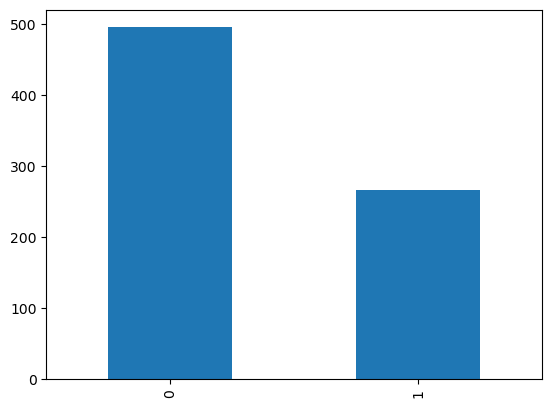

In [682]:
print(df.Outcome.value_counts())
p=df.Outcome.value_counts().plot(kind="bar")

In [581]:
counts = df.Outcome.value_counts()
percs = df.Outcome.value_counts(normalize=True)
pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])

,count,percentage
0,495,0.649606
1,267,0.350394


***495 people does not have diabetes and 267 does***

### 1. Pregnancies vs Outcome

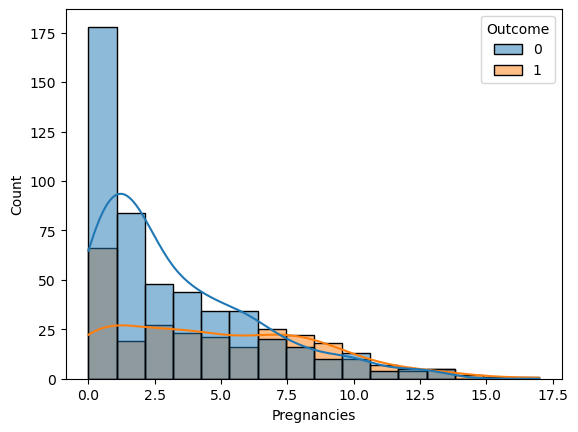

In [709]:
sns.histplot(x="Pregnancies", hue="Outcome", data=df, kde=True)
plt.savefig('pregr.png')

### from the above observation, the person with 0 pregnancies doesn't have diabetes by maximum

### 2. BloodPressure vs Outcome

<AxesSubplot:xlabel='BloodPressure', ylabel='Count'>

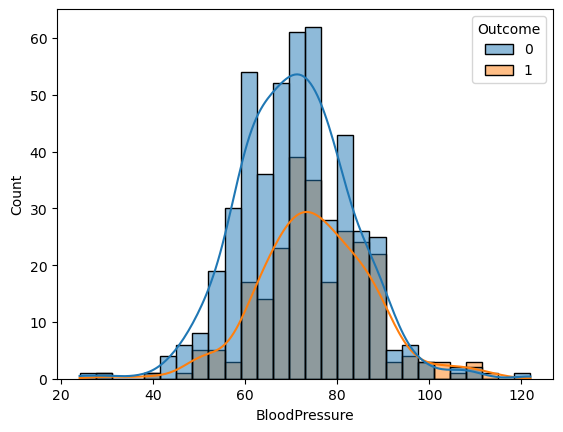

In [583]:
sns.histplot(x="BloodPressure", hue="Outcome", data=df, kde=True)

### the most people who are diabetic have Bloodpressure ranging from 50 to 90 

<AxesSubplot:xlabel='Glucose', ylabel='Count'>

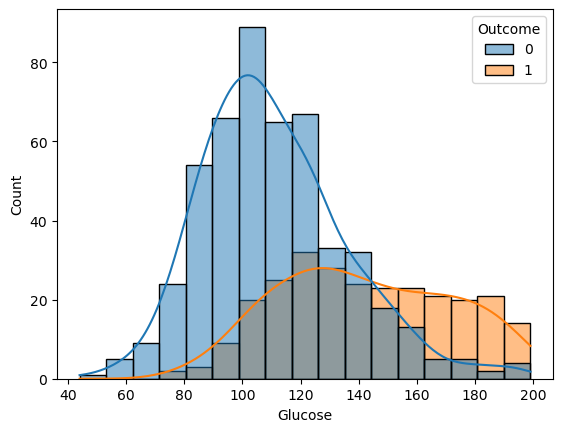

In [584]:
sns.histplot(x="Glucose", hue="Outcome", data=df, kde=True)

### as per the research, a person whose glucose level exceeds 125mg/dL have diabetes, similarly from the above observation, glucose value ranging from 110 to 200 are diabetic

<AxesSubplot:xlabel='SkinThickness', ylabel='Count'>

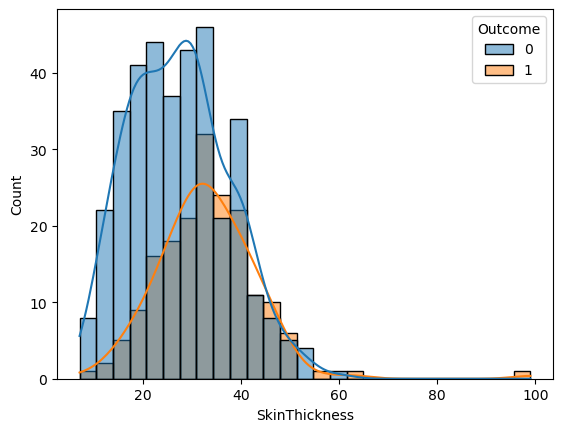

In [585]:
sns.histplot(x="SkinThickness", hue="Outcome", data=df, kde=True)

<AxesSubplot:xlabel='Insulin', ylabel='Count'>

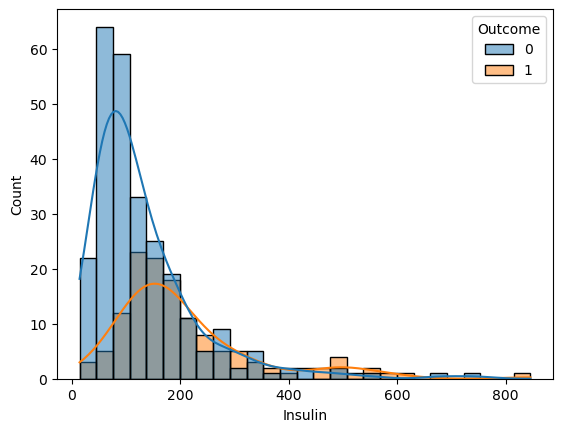

In [586]:
sns.histplot(x="Insulin", hue="Outcome", data=df, kde=True)

### here, both diabetic and non diabetic are right skewed that indicates the insulin value majorly lies between 0 to 200 

<AxesSubplot:xlabel='Age', ylabel='Count'>

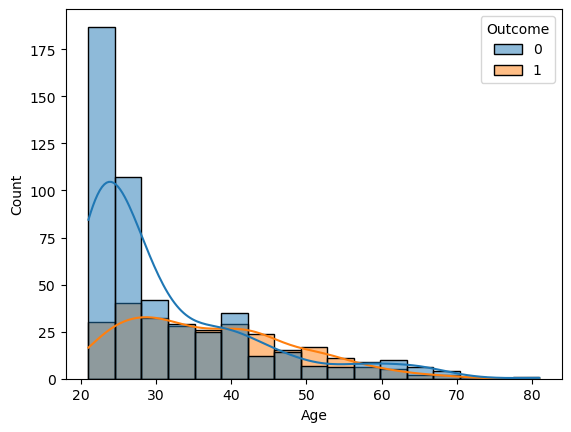

In [587]:
sns.histplot(x="Age", hue="Outcome", data=df, kde=True)

<AxesSubplot:xlabel='BMI', ylabel='Count'>

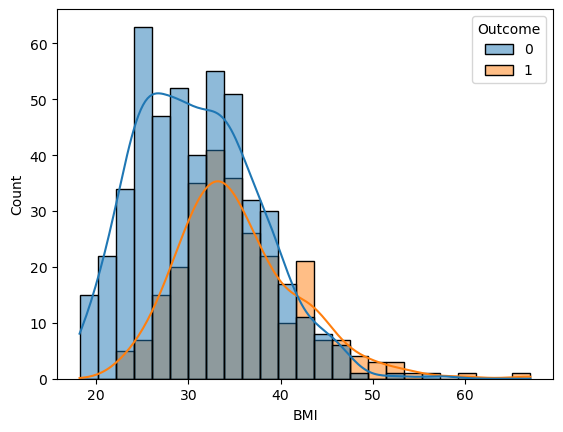

In [588]:
sns.histplot(x="BMI", hue="Outcome", data=df, kde=True)

<AxesSubplot:xlabel='DiabetesPedigreeFunction', ylabel='Count'>

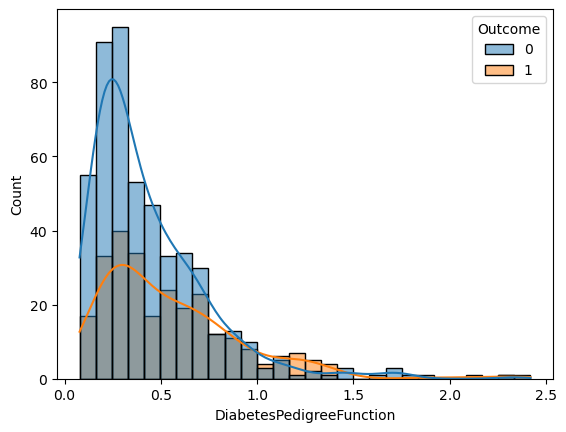

In [589]:
sns.histplot(x="DiabetesPedigreeFunction", hue="Outcome", data=df, kde=True)

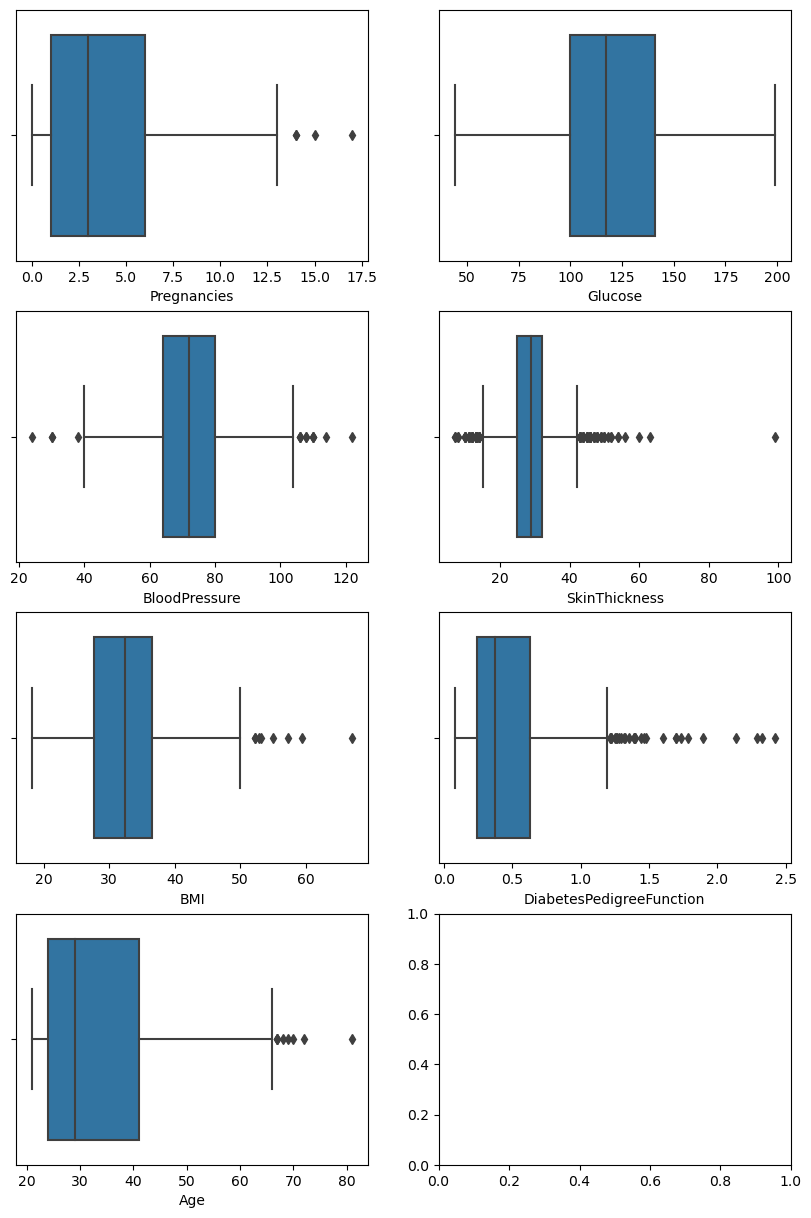

In [710]:
fig, axs = plt.subplots(4, 2, figsize=(10,15))
axs = axs.flatten()
for i in range(len(df.columns)-1):
    sns.boxplot(data=df, x=df.columns[i], ax=axs[i])
plt.savefig('boxplot.png')

### from the above observation, there are more number of outliers present in features like 'DiabetesPedigreeFunction', 'Insulin', 'Bloodpressure' and 'BMI'

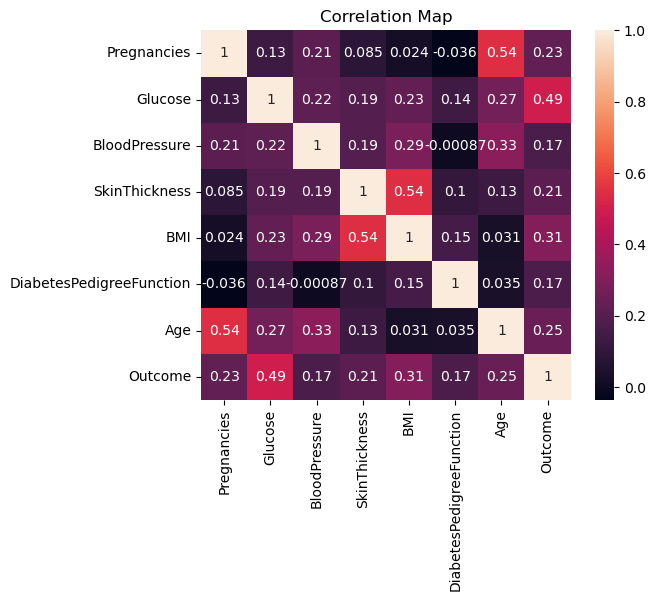

In [711]:
sns.heatmap(df.corr(), square=True, vmax = 1.0, linecolor='white', annot=True).set_title("Correlation Map")
plt.savefig('heatmap.png')

***0.5<corr<1 --> good positive correlation, means as x value increases y value increases***

***0<corr<0.5 --> positive correlation***

***corr = 0 --> no correlation, indicates there is no correlation between x and y***

### from the above plot, we can see

#### 1.Number of pregnancies increases with increase in Age

#### 2.Person having high BMI also has high skin thickness

#### 3.Person with high glucose level also have high Insulin level
    

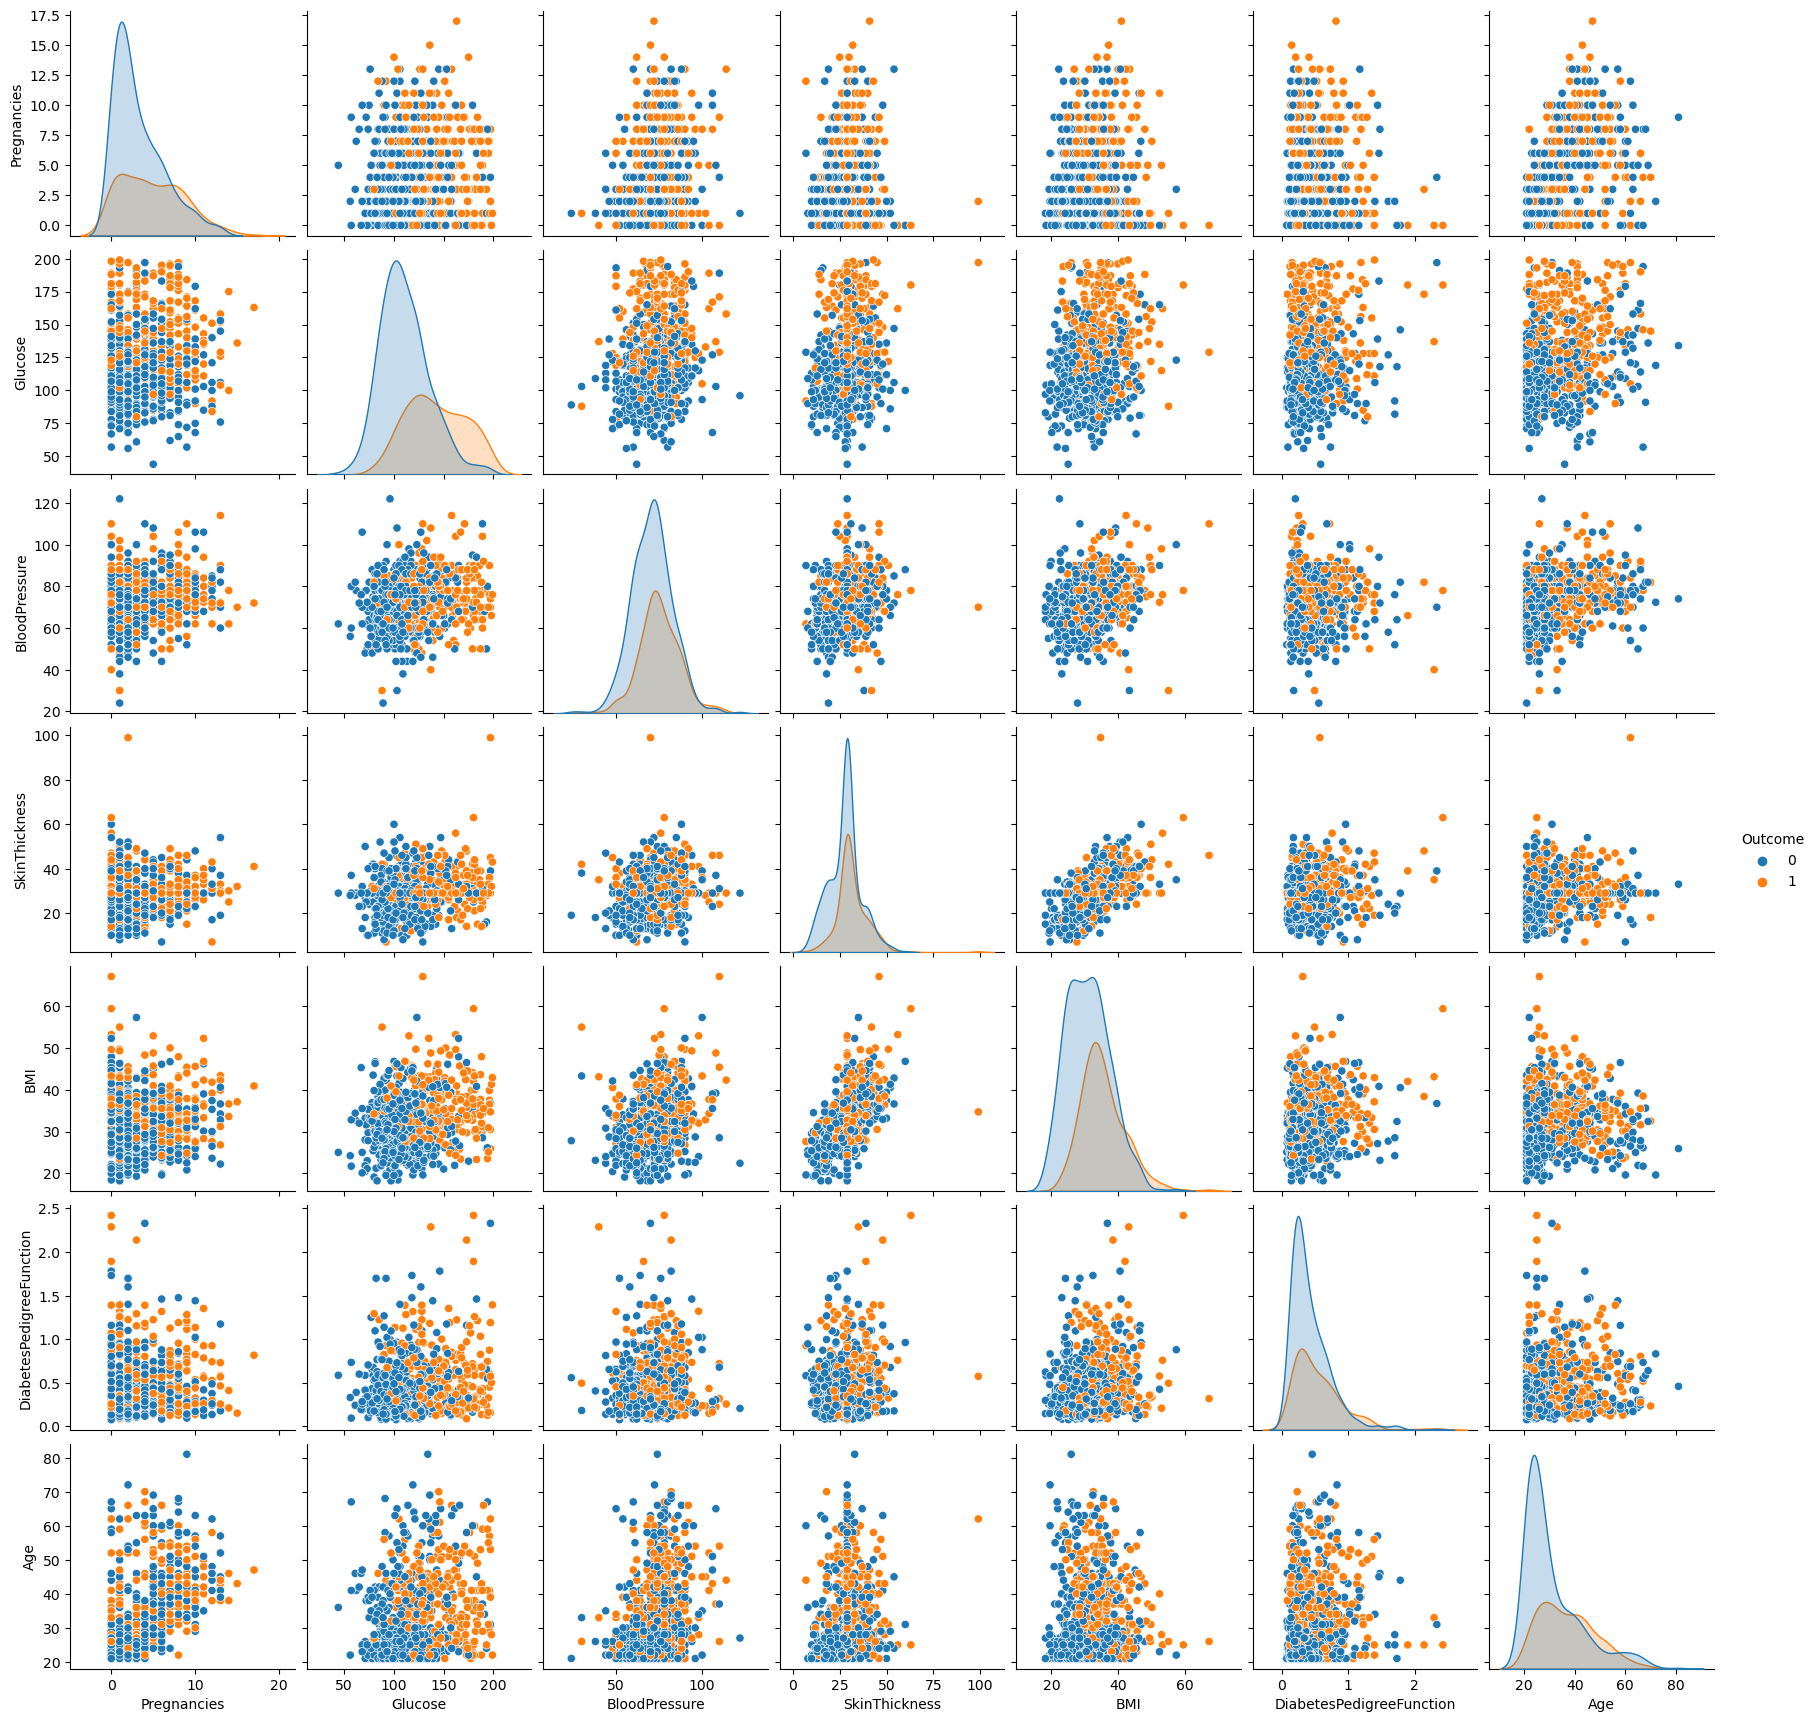

In [712]:
s = sns.pairplot(df, hue='Outcome')
plt.savefig('pairplot.png')

### from the above observation, we found

#### Bloodpressure ranges from 50 to 100 irrespective of age
#### Skinthickness value does not exceed 50 though age increases
#### As BMI value increases, Skinthickness value increses

# Handling Missing Values

In [593]:
# Handling missing values
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               222
Insulin                     368
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

<AxesSubplot:>

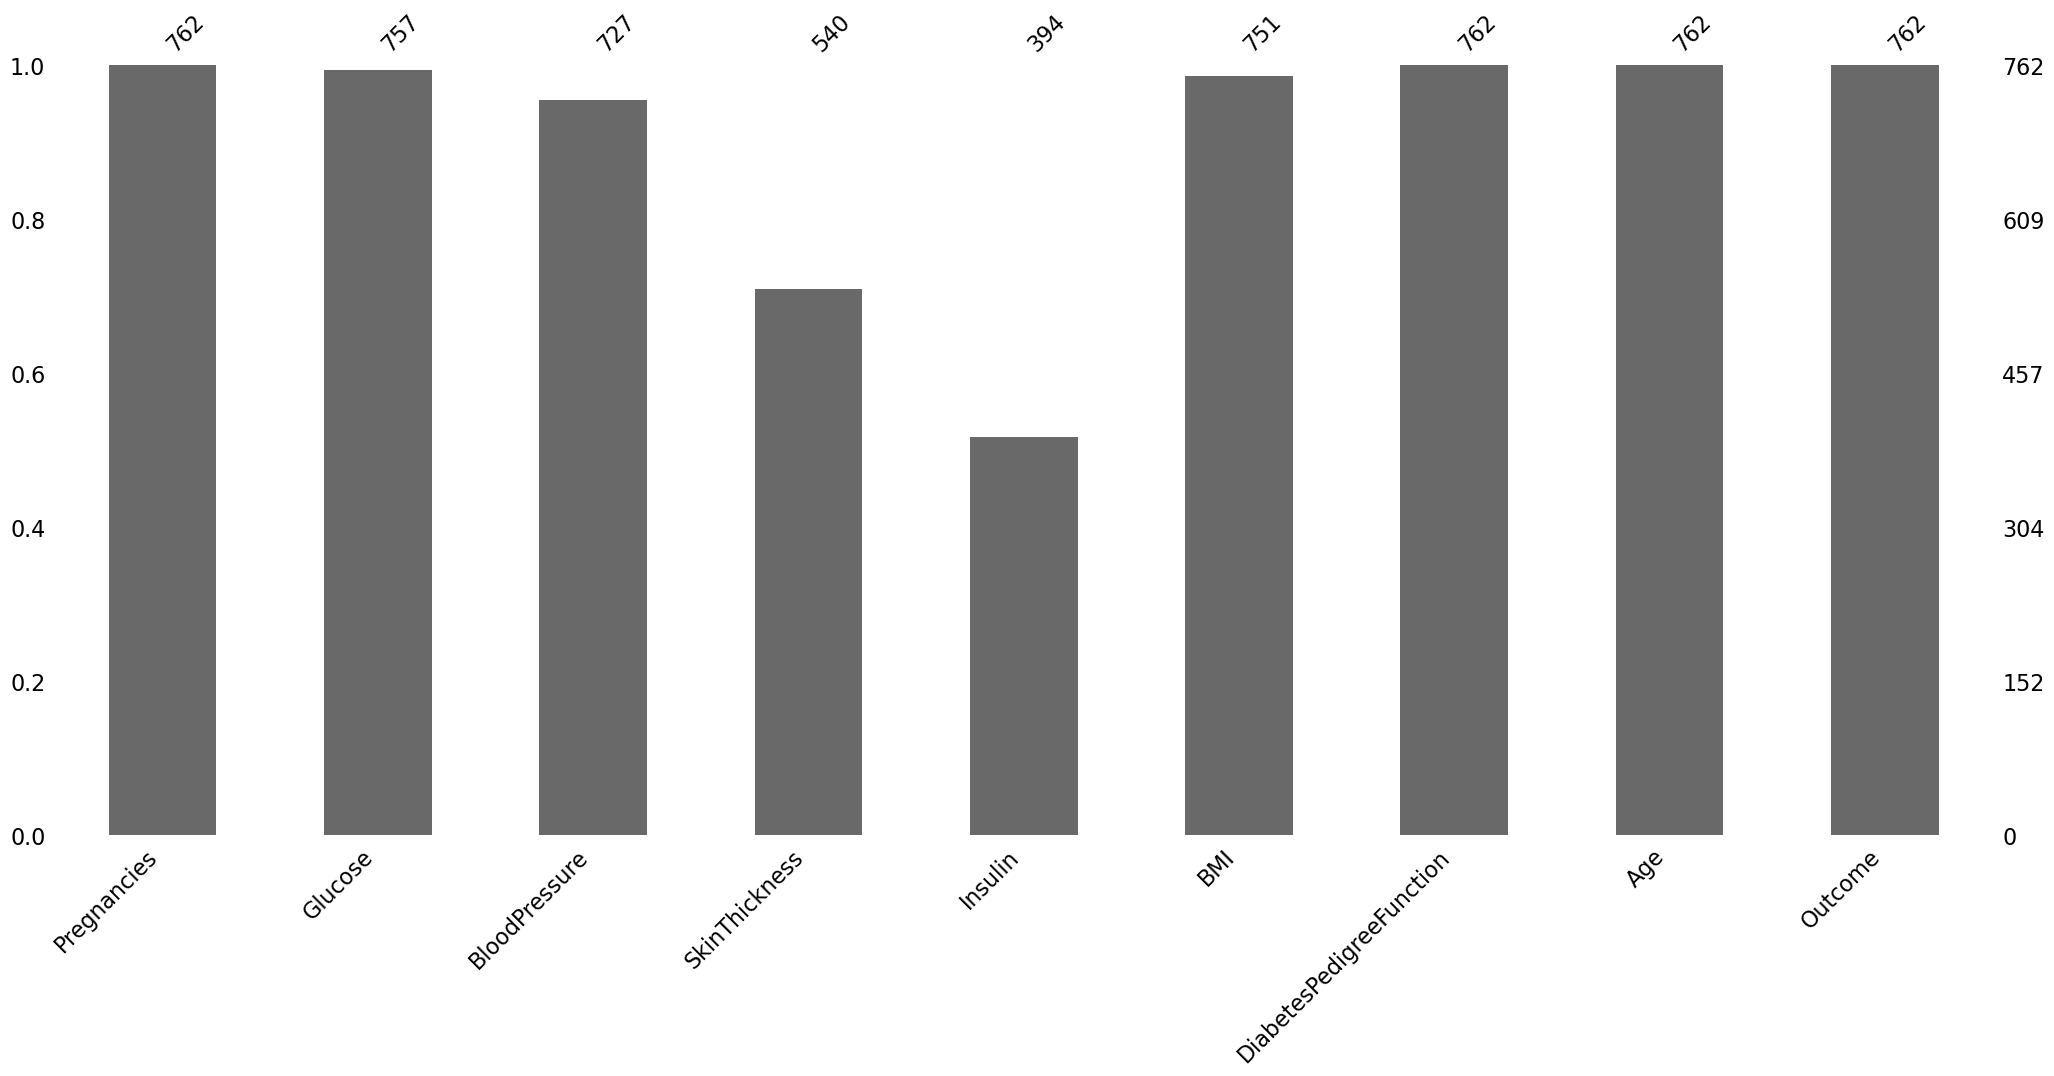

In [594]:
# plotting the missing value
msno.bar(df)

<AxesSubplot:>

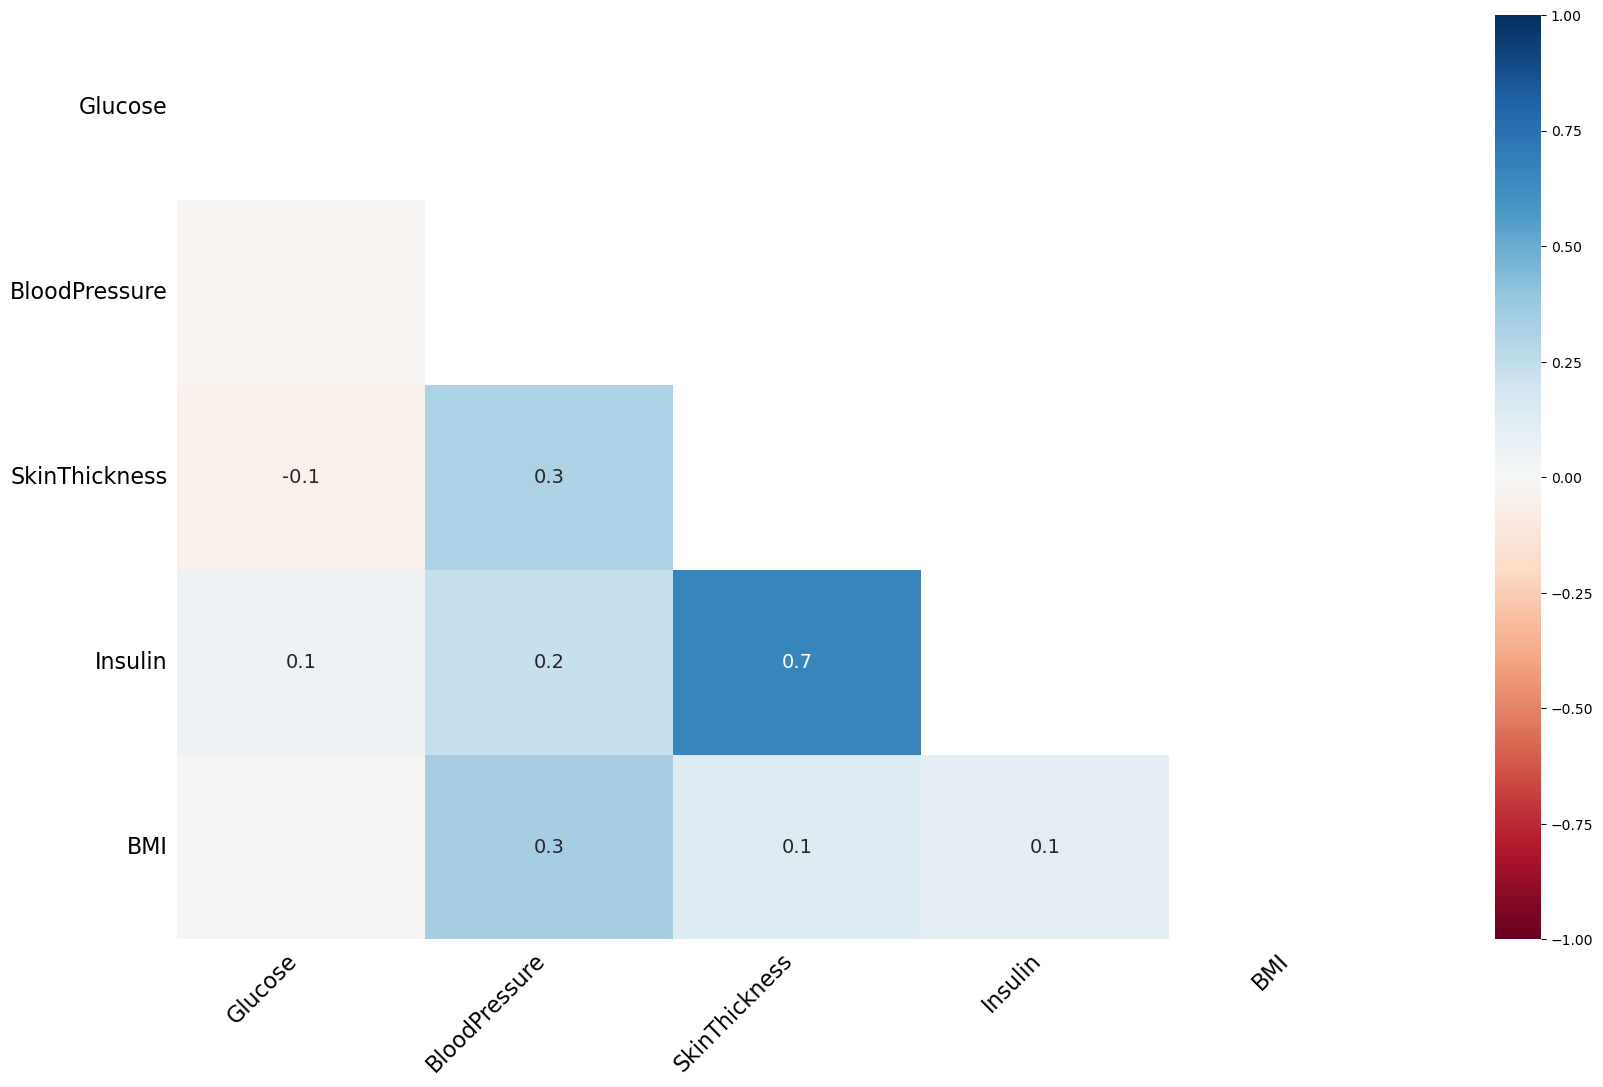

In [595]:
msno.heatmap(df)

   ***Skin thickness and Insulin are highly correlated***
   
   ***which means the feature skin thickness and insulin have more null values relatively***

In [596]:
df.isnull().sum()/ len(df) * 100

Pregnancies                  0.000000
Glucose                      0.656168
BloodPressure                4.593176
SkinThickness               29.133858
Insulin                     48.293963
BMI                          1.443570
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64

***nearly 50 percent of Insulin data is null, so dropping the column***

In [597]:
df.drop(columns=["Insulin"], inplace=True)

In [598]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [599]:
# checking for skewness
df.skew()

Pregnancies                 0.905988
Glucose                     0.532280
BloodPressure               0.134382
SkinThickness               0.688476
BMI                         0.587607
DiabetesPedigreeFunction    1.912009
Age                         1.127306
Outcome                     0.628395
dtype: float64

***A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. A value between 0.5 and 1 or -0.5 and -1 is moderately skewed.A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.***

***For highly skewed values we'll impute the column with median else mean.***

  ***so here, BMI, Skinthickness get imputed with median and remaining BP, 

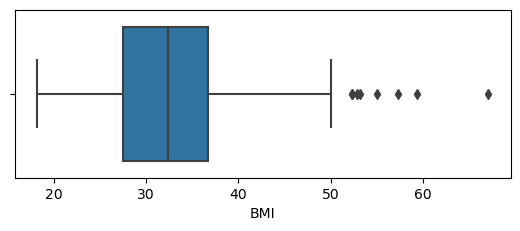

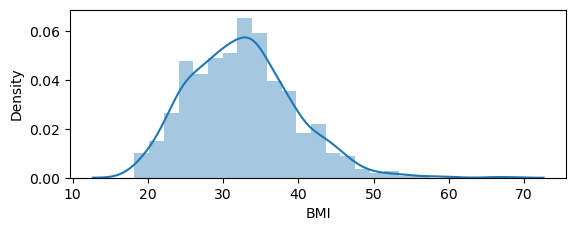

In [600]:
plt.subplot(2,1,1)
sns.boxplot(df.BMI)
plt.show()

plt.subplot(2,1,2)
sns.distplot(df.BMI)
plt.show()

***from the above plot, In BMI feature, Mean value imputation is preferred as the distribution is lighlty symmetrical***

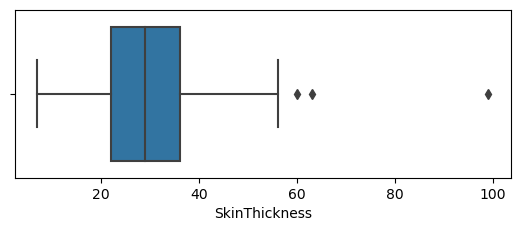

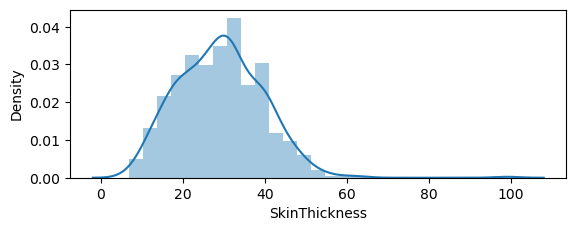

In [601]:
plt.subplot(2,1,1)
sns.boxplot(df.SkinThickness)
plt.show()

plt.subplot(2,1,2)
sns.distplot(df.SkinThickness)
plt.show()

***from the above plot, In Skin thickness feature, Median value imputation is preferred as the distribution is skewed and also has more outliers***

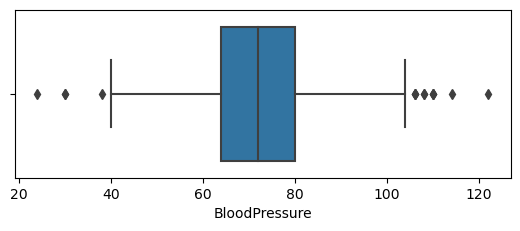

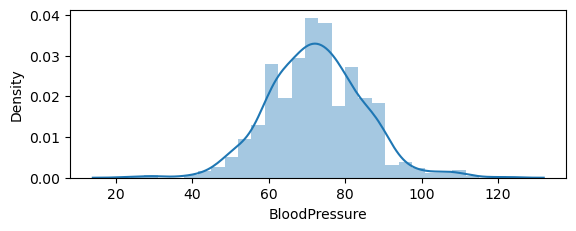

In [602]:
plt.subplot(2,1,1)
sns.boxplot(df.BloodPressure)
plt.show()

plt.subplot(2,1,2)
sns.distplot(df.BloodPressure)
plt.show()

***from the above plots, In BP feature, Mean imputation is preferred because the distribution is normal(Gaussian distribution)***

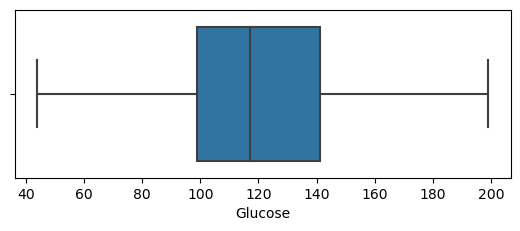

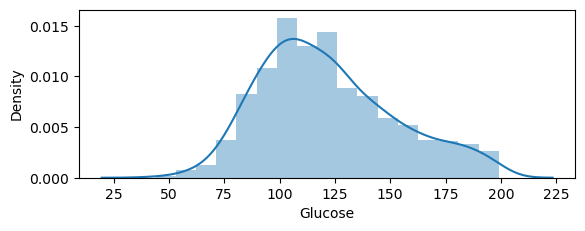

In [603]:
plt.subplot(2,1,1)
sns.boxplot(df.Glucose)
plt.show()

plt.subplot(2,1,2)
sns.distplot(df.Glucose)
plt.show()

***from the above plot, In Glucose feature, Median value imputation is preferred as the distribution is skewed***


***as a result,***

***-null values of BMI, SkinThickness are replaced by median value***

***-null values of BlooPressure, Glucose is replaced by mean value***

In [604]:
# Median value imputation
df["BMI"].replace(to_replace=np.nan,value=df["BMI"].median(), inplace=True)
df["SkinThickness"].replace(to_replace=np.nan,value=df["SkinThickness"].median(), inplace=True)

# Mean value imputation
df["Glucose"].replace(to_replace=np.nan,value=df["Glucose"].mean(), inplace=True)
df["BloodPressure"].replace(to_replace=np.nan,value=df["BloodPressure"].mean(), inplace=True)

In [605]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [606]:
new_df = df

# Model Implementation
   ## 1. Support Vector Machine
   
   ## 2. K nearest neighbor
   
   ## 3. Decision Tree Classifier

### Data Splitting

*** Separating independent variables and target ***

In [607]:
X = new_df.drop('Outcome', axis = 1)
Y = new_df['Outcome']

In [608]:
X.shape, Y.shape

((762, 7), (762,))

### Data Scaling

*** As the features are not in same measurements ***

In [609]:
scaler = StandardScaler()
scaler.fit(X)
std_data = scaler.transform(X)

In [610]:
print(std_data)

[[ 0.64038776  0.86171783 -0.03082365 ...  0.1597802   0.46347017
   1.43905445]
 [-0.84462585 -1.20684738 -0.52695929 ... -0.85894752 -0.36817103
  -0.18776138]
 [ 1.2343932   2.01092072 -0.69233784 ... -1.33920487  0.59906384
  -0.10213949]
 ...
 [ 0.34338504 -0.02481012 -0.03082365 ... -0.91716053 -0.68756946
  -0.27338327]
 [-0.84462585  0.13936172 -1.02309493 ... -0.34958366 -0.37419741
   1.18218879]
 [-0.84462585 -0.94417243 -0.1962022  ... -0.3059239  -0.47664597
  -0.87273647]]


In [611]:
X = std_data
Y = new_df['Outcome']

### Splitting data into train and test

In [612]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, stratify = Y, random_state = 5)

In [613]:
print(X.shape, x_train.shape, x_test.shape)

(762, 7) (609, 7) (153, 7)


# 1. Support Vector Machine

In [714]:
model1 = svm.SVC(kernel = 'linear', C= 10.0)

*** training the model***

In [719]:
model1.fit(x_train, y_train)
svm_y_pred = model1.predict(x_test)

*** Evaluating the model using evaluation metrics ***

***1. Accuracy_score

***2. Precision and Recall

***3. F1 Score

***4. ROC Curve

In [617]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, RocCurveDisplay, roc_auc_score

*** Confusion matrix ***

In [618]:
conf_matrix_svm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)
print(conf_matrix_svm)

[[86 13]
 [29 25]]


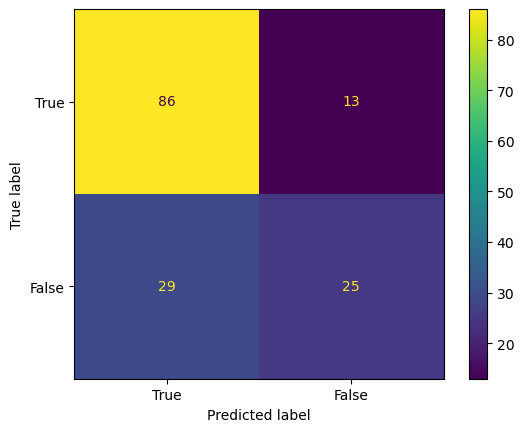

In [619]:
# plotting the confusion matrix:
display = ConfusionMatrixDisplay(conf_matrix_svm, display_labels = [True, False])
display.plot()
plt.show()


***Precision = True Positive / (True Positive + False Positive)***

***Recall = True Positive / (True Positive + False negative)***

***F1 score = 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))***

***Accuracy = (True Positive + True Negative) / Total Predictions***

***ROC_AUC --> Plotting between TruePositive Rate and FalsePositive rate***

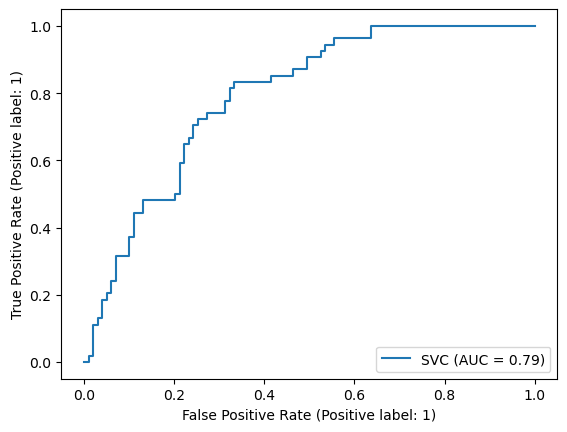

In [620]:
precision = precision_score(y_test, svm_y_pred)
recall = recall_score(y_test, svm_y_pred)
f1score = f1_score(y_test, svm_y_pred)
accuracy = accuracy_score(y_test, svm_y_pred)
roc = RocCurveDisplay.from_estimator(model1, x_test, y_test)

In [621]:
print('Evaluation score for Support Vector Machine')
print('precision    : %0.2f ' % precision)
print('recall       : %0.2f ' % recall)
print('f1 score     : %0.2f ' % f1score)
print('accuracy     : %0.2f ' % accuracy)

Evaluation score for Support Vector Machine
precision    : 0.66 
recall       : 0.46 
f1 score     : 0.54 
accuracy     : 0.73 


### we can consider AUC score value, as Area Under ROC curve is the best evaluation metric for classification data prediction

### Model       - Support Vector Classifier
### Accuracy - 79%

# Making a Predictive System
* Provide the input for 7 features and check wether the predictions is correct or not

In [683]:
# input_data = list(map(float,input().split()))[:7]

# # changing data to numpy array
# a = np.asarray(input_data)

# # Reshaping the array into a single set of input
# reshape = a.reshape(1,-1)

# # scaling the input data, as we used data scaling for training the dataset
# scaled = scaler.transform(reshape)
# print('----------------')
# print(scaled)
# print('----------------')

# # now. predict the output
# pred = model1.predict(scaled)
# print(pred)

# if pred[0] == 0:
#     print('the person is non diabetic')
# else:
#     print('the person is diabetic')

5 120 40 2 0.256 52 30
----------------
[[ 3.43385036e-01 -5.76444855e-02 -2.67688041e+00 -3.07841683e+00
  -4.69285652e+00  1.55260220e+02 -2.73383265e-01]]
----------------
[1]
the person is diabetic


C:\Users\nooru\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



# 2. K nearest neighbor
 ### Finding the best Value of K to reduce overfitting

In [630]:
k = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]
for i in k:
    model2 = KNeighborsClassifier(i, metric = 'minkowski')
    model2.fit(x_train,y_train)
    print("K value  : " , i, " train score : ", model2.score(x_train,y_train) , " cv score : ", np.mean(cross_val_score(model2, x_train, y_train, cv=10)))

K value  :  1  train score :  1.0  cv score :  0.6914207650273224
K value  :  2  train score :  0.8390804597701149  cv score :  0.6913387978142077
K value  :  3  train score :  0.8292282430213465  cv score :  0.7209016393442623
K value  :  4  train score :  0.7931034482758621  cv score :  0.7094262295081968
K value  :  5  train score :  0.8144499178981938  cv score :  0.730792349726776
K value  :  6  train score :  0.8045977011494253  cv score :  0.732431693989071
K value  :  7  train score :  0.7996715927750411  cv score :  0.7439071038251366
K value  :  8  train score :  0.7865353037766831  cv score :  0.7373497267759563
K value  :  9  train score :  0.7980295566502463  cv score :  0.7619945355191258
K value  :  10  train score :  0.7947454844006568  cv score :  0.7603551912568306
K value  :  15  train score :  0.7848932676518884  cv score :  0.7504918032786885
K value  :  20  train score :  0.7816091954022989  cv score :  0.7455464480874316
K value  :  25  train score :  0.781609195

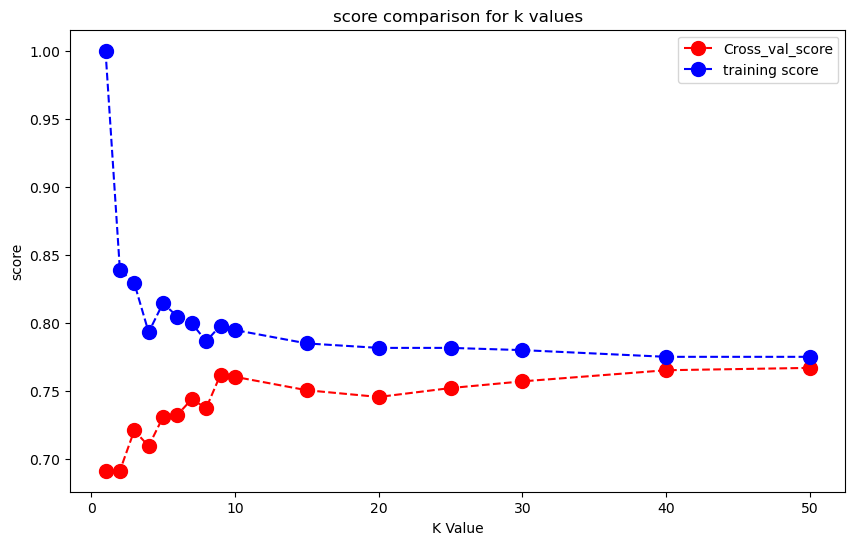

In [684]:
cross_score = []
train_score = []
for i in k:
    model2 = KNeighborsClassifier(n_neighbors=i)
    model2.fit(x_train, y_train)
    kn_y_pred = model2.predict(x_test)
    train_score.append(np.asarray(model2.score(x_train, y_train)))
    cross_score.append(np.mean(cross_val_score(model2, x_train, y_train, cv = 10)))
plt.figure(figsize=(10, 6))
plt.plot(k, cross_score, color='red', linestyle='dashed', marker='o', markersize=10, label = 'Cross_val_score')
plt.plot(k, train_score, color='blue', linestyle='dashed', marker='o', markersize=10, label = 'training score')
plt.legend(loc = 'upper right')
plt.title('score comparison for k values')
plt.xlabel('K Value')
plt.ylabel('score')
plt.show()

## k = 50

***from the above results, the best value of k is 50 because the training score and the cross validation score are somehow similar which avoids overfitting and underfitting***

***the remaining plots are having higher the training score but failing the cross validation score/test score. This indicates except k = 20, all other model leads to overfitting*** 

### Evaluating the model using evaluation metrics

***1. Accuracy_score

***2. Precision and Recall

***3. F1 Score

***4. ROC Curve

In [632]:
conf_matrix_knn = confusion_matrix(y_test, kn_y_pred)
print(conf_matrix_knn)

[[85 14]
 [35 19]]


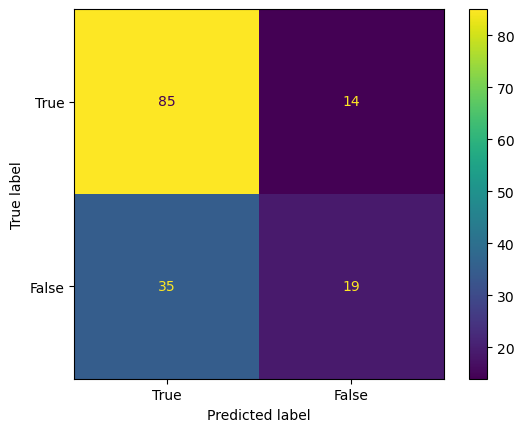

In [633]:
# plotting the confusion matrix:
display = ConfusionMatrixDisplay(conf_matrix_knn, display_labels = [True, False])
display.plot()
plt.show()

precision    : 0.50 
recall       : 0.48 
f1score      : 0.49 
accuracy     : 0.65 


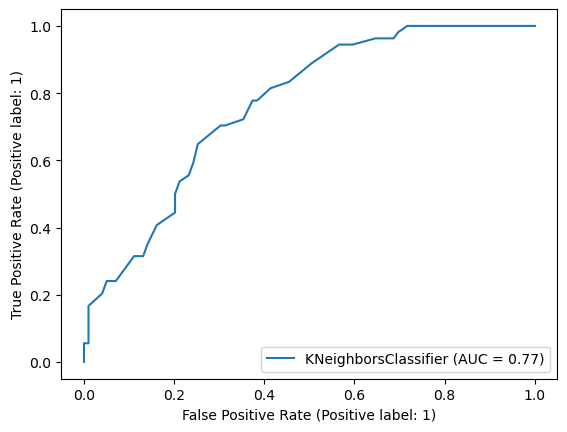

In [635]:
precision = precision_score(y_test, y_pred)
print('precision    : %0.2f ' % precision)
recall = recall_score(y_test, y_pred)
print('recall       : %0.2f ' % recall)
f1score = f1_score(y_test, y_pred)
print('f1score      : %0.2f ' % f1score)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy     : %0.2f ' % accuracy)
roc = RocCurveDisplay.from_estimator(model2, x_test, y_test)

### from the above observation, the model 'K Nearest Neighbor' gives an Accuracy (AUC) of 77%

# 3. Decision Tree
   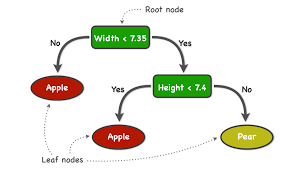

In [636]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth 
dt = DecisionTreeClassifier()

# Fit dt to the training set
dt.fit(x_train, y_train)

# Predict test set labels
y_pred = dt.predict(x_test)
y_pred

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

### Evaluating the model using evaluation metrics 

precision    : 0.49 
recall       : 0.52 
f1score      : 0.50 
accuracy     : 0.64 


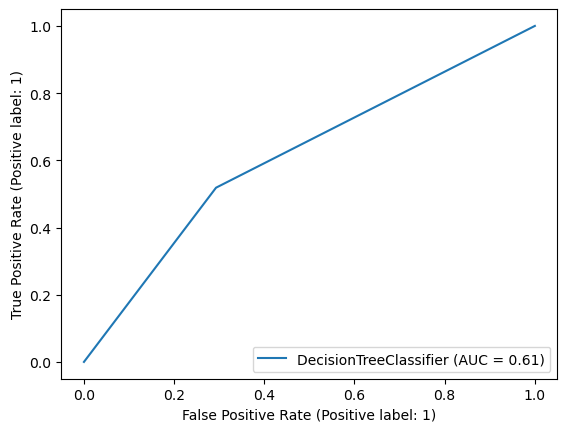

In [637]:
precision = precision_score(y_test, y_pred)
print('precision    : %0.2f ' % precision)
recall = recall_score(y_test, y_pred)
print('recall       : %0.2f ' % recall)
f1score = f1_score(y_test, y_pred)
print('f1score      : %0.2f ' % f1score)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy     : %0.2f ' % accuracy)
roc = RocCurveDisplay.from_estimator(dt, x_test, y_test)

## Finding the max_depth to avoid overfitting


In [647]:
from sklearn.model_selection import cross_val_score 
import numpy as np
val = [1,2,3,4,5,6,7,8,9,10]
for depth in val:
  dt = DecisionTreeClassifier(max_depth=depth) 
  # Fit dt to the training set
  dt.fit(x_train, y_train) 
  trainAccuracy = accuracy_score(y_train, dt.predict(x_train)) 
  dt = DecisionTreeClassifier(max_depth=depth) 
  valAccuracy = cross_val_score(dt, x_train, y_train, cv=10) 
  print("Depth  : ", depth, " Training Accuracy : ", trainAccuracy, " Cross val score : " ,np.mean(valAccuracy))

Depth  :  1  Training Accuracy :  0.7619047619047619  Cross val score :  0.7258469945355192
Depth  :  2  Training Accuracy :  0.7668308702791461  Cross val score :  0.7405464480874318
Depth  :  3  Training Accuracy :  0.7701149425287356  Cross val score :  0.7356284153005463
Depth  :  4  Training Accuracy :  0.8045977011494253  Cross val score :  0.7159289617486339
Depth  :  5  Training Accuracy :  0.8160919540229885  Cross val score :  0.7028415300546448
Depth  :  6  Training Accuracy :  0.8669950738916257  Cross val score :  0.6863114754098361
Depth  :  7  Training Accuracy :  0.8949096880131363  Cross val score :  0.6979234972677596
Depth  :  8  Training Accuracy :  0.9244663382594417  Cross val score :  0.6781967213114755
Depth  :  9  Training Accuracy :  0.9507389162561576  Cross val score :  0.6880601092896175
Depth  :  10  Training Accuracy :  0.9704433497536946  Cross val score :  0.6881147540983606


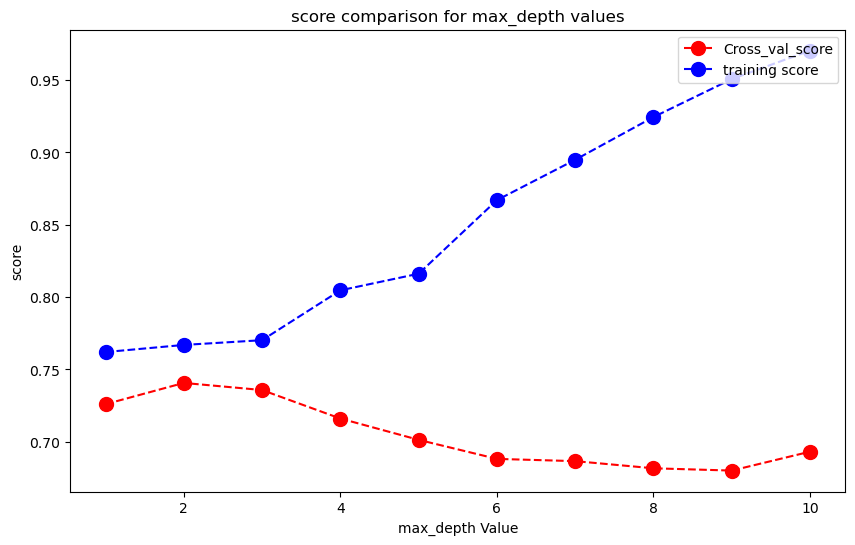

In [680]:
cross_score = []
train_score = []
for i in val:
    dt = DecisionTreeClassifier(max_depth = i)
    dt.fit(x_train, y_train)
    kn_y_pred = dt.predict(x_test)
    train_score.append(np.asarray(dt.score(x_train, y_train)))
    cross_score.append(np.mean(cross_val_score(dt, x_train, y_train, cv = 10)))
plt.figure(figsize=(10, 6))
plt.plot(val, cross_score, color='red', linestyle='dashed', marker='o', markersize=10, label = 'Cross_val_score')
plt.plot(val, train_score, color='blue', linestyle='dashed', marker='o', markersize=10, label = 'training score')
plt.legend(loc = 'upper right')
plt.title('score comparison for max_depth values')
plt.xlabel('max_depth Value')
plt.ylabel('score')
plt.show()

## Max depth = 2

***from the above results, the best value of max_depth is 2 because the training score and the cross validation score are somehow came closer which avoids overfitting and underfitting***

***the remaining plots are having higher the training score but failing the cross validation score/test score. This indicates except max_depth = 2, all other model leads to overfitting***

# Hyperparameter Tuning
## 1. Support Vector Machine

In [649]:
from sklearn.model_selection import GridSearchCV

In [718]:
param_grid = {'kernel':['rbf', 'poly', 'sigmoid', 'linear'], 'degree':[1,2,3,4,5], 'C':[0.1, 1, 100, 1000]}
grid = GridSearchCV(svm.SVC(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 1000], 'degree': [1, 2, 3, 4, 5],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [653]:
print(grid.best_params_)
print(grid.score(x_test, y_test))

{'C': 0.1, 'degree': 1, 'kernel': 'linear'}
0.7189542483660131


In [717]:
print(grid.best_params_)
print(grid.score(x_train, y_train))

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 15}


In [716]:
svm.SVC?

### from the above result, the best hyperparameter for the SVM has been chosen in order to get maximum efficiency.
#### C - (support vector Classification): 0.1
#### degree - (degree of polynomial kernel function) : 1
#### kernel - (kernel type) : Linear

# 2. K Nearest Neighbor

In [662]:
grid_params = { 'n_neighbors' : [10,20,30,40,50], 'weights' : ['uniform','distance'], 
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, cv = 3)
res = gs.fit(x_train,y_train)

In [669]:
print(res.best_score_)
print(res.best_params_)

0.7635467980295566
{'metric': 'minkowski', 'n_neighbors': 50, 'weights': 'uniform'}


### from the above result, the best hyperparameter for the KNN has been chosen in order to get maximum efficiency.
#### n_neighbors - (Number of neighbors): 50
#### weights - ({‘uniform’, ‘distance’}) : uniform
#### metric - (Metric to use for distance computation) : minkowski

# 3. Decision Tree Classifier

In [678]:
param_dist = {'criterion': ['gini', 'entropy'], 'max_depth': [1,2,3,4,5,6,7,8,9,10], 
             'min_samples_leaf': [5,10,15, 20,30,50]}
tree = DecisionTreeClassifier()
grid = GridSearchCV(tree, param_dist, cv = 5)
res = grid.fit(x_train, y_train)

In [679]:
print(res.best_score_)
print(res.best_params_)

0.7520661157024794
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 15}


In [681]:
DecisionTreeClassifier?

### from the above result, the best hyperparameter for the Decision Tree has been chosen in order to get maximum efficiency.
#### criterion - (The function to measure the quality of a split, {'gini', 'entropy'}): entropy
#### max_depth - (The maximum depth of the tree) : 5
#### min_samples_leaf - (The minimum number of samples required to be at a leaf node) : 15